## 要求

1）根据语音分帧的思想，编写分帧函数。函数定义如下： 
函数格式：frameout=enframe(x,win,inc)。 
输入参数：x 是语音信号；win 是帧长或窗函数，若为窗函数，帧长便取窗函数长；inc
是帧移。 
输出参数：frameout 是分帧后的数组，长度为帧长和帧数的乘积。 
根据分帧后的语音，绘制连续四帧语音信号（不用窗函数)

In [119]:
# -*- coding:utf-8
import numpy as np
import soundfile
import pyaudio #录制和播放
import wave # 导入wave库，处理音频
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile #读取wav提取数据
from pydub import AudioSegment #　音频处理
plt.rcParams['font.family'] = 'simhei'
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体（可以根据需要选择其他字体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [142]:
def play_audio(rate,file_name): # rate 采用率 file_name保存文件名
    Chunk = 1024 # 读取的音频帧的大小
    Format = pyaudio.paInt16 #　音频格式为16位的整数
    Channels = 1 # 通道为2
    Rate = rate #采用率
    Record_times = 5 # 录制时间
    Nframes = int(Rate / Chunk * Record_times) # 计算出所需采集帧的数量
    File_name = file_name
    
    # 实例化一个对象
    p = pyaudio.PyAudio()
    
    # 使用该对象打开声卡，进入参数配置
    stream = p.open(format = Format,
                    channels = Channels,
                    rate = Rate,
                    input = True,
                    frames_per_buffer = Chunk)
    print("开始录音，整个过程持续五秒钟!!!")
    frames = []
    for i in range(0,Nframes):
        data = stream.read(Chunk)
        frames.append(data)
    print("完成录音!!!")
    
    # 关闭
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    # 存储wav
    wf = wave.open(File_name,'wb') # 写入wav文件
    wf.setnchannels(Channels)# 设置通道数
    wf.setsampwidth(p.get_sample_size(Format)) # 设置样本宽度
    wf.setframerate(Rate)# 设置采样率
    wf.writeframes(b''.join(frames)) # 将列表的数据会合写入文件
    wf.close()
    print(f"语音保存为{File_name}")
    

In [143]:
play_audio(16000,"实验3.wav")

开始录音，整个过程持续五秒钟!!!
完成录音!!!
语音保存为实验3.wav


In [144]:
def enframe(x, win, inc):
    frame_length = len(win)
    num_frames = (len(x) - frame_length) // inc + 1

    frameout = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        start = i * inc
        end = start + frame_length
        frameout[i, :] = x[start:end] * win

    return frameout

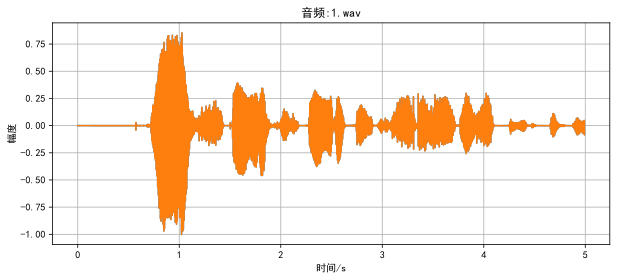

In [145]:
# 读取 WAV 文件
sample_rate, data = wavfile.read("./实验3.wav")
# 获取信号的时长（秒）
duration = len(data) / sample_rate
# 创建时间轴（横轴）数据
time_axis = np.arange(data.shape[0]) / sample_rate
# 归一化音频数据
normalized_data = data / np.max(np.abs(data),axis=0)
# 绘制图形
plt.figure(figsize=(10, 4))
plt.plot(time_axis, normalized_data)
plt.xlabel("时间/s")
plt.ylabel("幅度")
plt.title("音频:1.wav")
plt.grid(True)
plt.show()

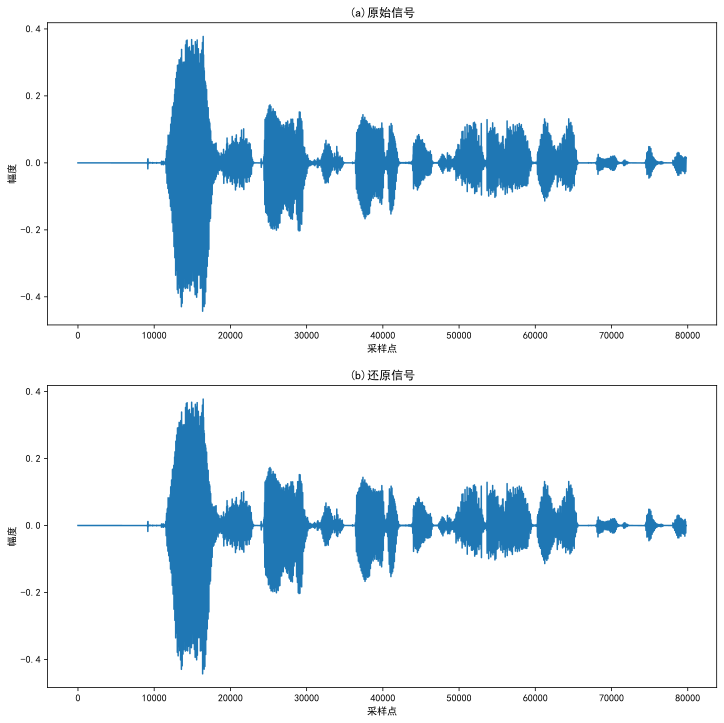

In [146]:
# 读取音频文件
s, fs = soundfile.read('实验3.wav')  # 将文件读取为信号 s，并获取采样率 fs
Slen = len(s)  # 获取信号的长度
FFTLen = 128  # 定义 FFT 长度
FrameLen = 64  # 定义帧长
win = np.sin(np.linspace(0.5, FFTLen - 0.5, FFTLen) / FFTLen * np.pi).T  # 定义窗函数 win
ss = np.zeros(FFTLen)  # 初始化长度为 FFTLen 的零数组 ss
sst = np.zeros(FFTLen)  # 初始化长度为 FFTLen 的零数组 sst
frameoverlap = np.zeros(FFTLen - FrameLen)  # 初始化长度为 FFTLen-FrameLen 的零数组 frameoverlap
framenum = int(Slen / FrameLen) - 1  # 计算帧数
out = np.zeros(Slen)  # 初始化与输入信号长度相同的零数组 out

# 处理每一帧的数据
for kk in range(framenum):  # 循环每一帧
    pos = kk * FrameLen  # 计算帧的位置
    In = s[pos: pos + FrameLen, 0]  # 提取当前帧的数据
    ss[FFTLen - FrameLen:] = In  # 将当前帧数据添加到 ss 的末尾
    ss[0: FFTLen - FrameLen] = sst[FrameLen:]  # 将 sst 的一部分数据添加到 ss 的开头
    sst = ss.copy()  # 复制 ss 到 sst
    ss1 = ss * win  # 将窗函数应用于 ss
    fftss = np.fft.fft(ss1) 

    # 添加必要的算法，这部分需要根据具体算法进行注释

    ifftss = np.real(np.fft.ifft(fftss))  # 对 FFT 变换后的结果进行逆变换
    ifftss = ifftss * win  # 将窗函数应用于逆变换后的结果
    ifftss[0: FFTLen - FrameLen] = ifftss[0: FFTLen - FrameLen] + frameoverlap  # 添加重叠部分
    frameoverlap = ifftss[FrameLen:]  # 更新重叠部分
    out[pos: pos + FrameLen] = ifftss[0: FrameLen]  # 将处理后的数据添加到 out 中


out = out[(FFTLen - FrameLen):]  # 截取有效部分
lenout = len(out)  # 获取处理后信号的长度
re = np.zeros([2, lenout])  # 初始化 2 行 lenout 列的零数组 re
re[0, :] = s[0:lenout, 0]  # 将原始信号的第一列复制到 re 的第一行
re[1, :] = out  # 将处理后的信号复制到 re 的第二行
plt.figure(figsize=(12,12))
# 绘制图形
plt.subplot(2, 1, 1)  # 创建第一个子图
plt.plot(re[0, :])  # 绘制原始信号
plt.xlabel('采样点')  # 添加 x 轴标签
plt.ylabel('幅度')  # 添加 y 轴标签
plt.title('(a)原始信号')  # 添加标题

plt.subplot(2, 1, 2)  # 创建第二个子图
plt.plot(re[1, :])  # 绘制处理后的信号
plt.xlabel('采样点')  # 添加 x 轴标签
plt.ylabel('幅度')  # 添加 y 轴标签
plt.title('(b)还原信号')  # 添加标题
plt.show()  # 显示图形

# 将处理后的信号写入文件
soundfile.write('实验3处理.wav', out, fs)  # 将处理后的信号写入文件 sweepN.wav，采样率为 fs

In [147]:
# 读取文件
sample_rate,signal = wavfile.read("实验3.wav")
signal.shape

(79872, 2)

In [148]:
signal_left = signal[:,0] # 左声道
signal_right = signal[:,1] # 右声道

In [149]:
# 预加重处理
pre_emphasis = 0.95
signal_left_emphasis = np.append(signal_left[0],signal_left[1:] - pre_emphasis * signal_left[:-1])
signal_right_emphasis = np.append(signal_right[0],signal_right[1:] - pre_emphasis * signal_right[:-1])
print(signal_left.shape)
print(signal_right.shape)

(79872,)
(79872,)


In [150]:
# 分帧
frame_length = 400
frame_shift = 200
frame_left = [signal_left_emphasis[i:i+frame_length] for i in range(0,len(signal_left_emphasis)-frame_length,frame_shift)]
frame_right = [signal_right_emphasis[i:i+frame_length] for i in range(0,len(signal_right_emphasis)-frame_length,frame_shift)]

Text(0, 0.5, '振幅')

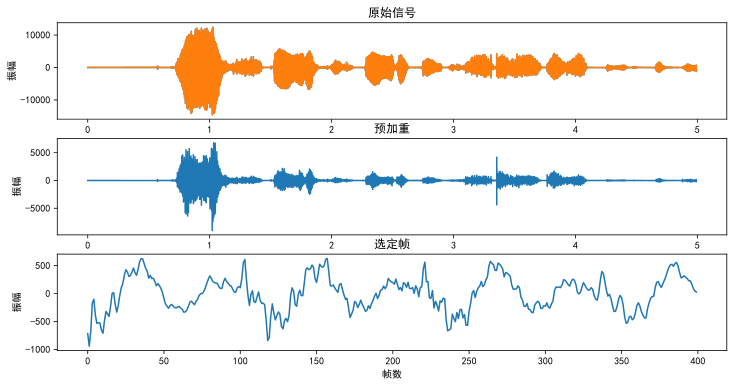

In [156]:
# 选择要展示的帧
frame_to_display = 190  # 假设选择第5帧进行展示

# 选择窗函数
frame_length = 400
frame_left_selected = frame_left[frame_to_display]
frame_right_selected = frame_right[frame_to_display]

# 加窗处理
hamming_window = np.hamming(frame_length)
hanning_window = np.hanning(frame_length)
rectangular_window = np.ones(frame_length)
triangular_window = 1 - np.abs(2 * np.arange(frame_length) - (frame_length - 1)) / (frame_length - 1)

windowed_frame_left_hamming = frame_left_selected * hamming_window
windowed_frame_right_hamming = frame_right_selected * hamming_window

# 合成波形
emphasized_signal_left = np.append(signal_left[0], signal_left[1:] - pre_emphasis * signal_left[:-1])
emphasized_signal_right = np.append(signal_right[0], signal_right[1:] - pre_emphasis * signal_right[:-1])

# 绘制图形
plt.figure(figsize=(12, 8))

# 原始信号
plt.subplot(4, 1, 1)
plt.plot(np.arange(len(signal))/sample_rate,signal)
plt.title('原始信号')
plt.xlabel("时间(s)")
plt.ylabel("振幅")



# 预加重信号
plt.subplot(4, 1, 2)
plt.plot(np.arange(len(emphasized_signal_left))/sample_rate,emphasized_signal_left)
plt.title('预加重')
plt.xlabel("时间(s)")
plt.ylabel("振幅")


plt.subplot(4, 1, 3)
plt.plot(frame_left_selected)
plt.title('选定帧')
plt.xlabel("帧数")
plt.ylabel("振幅")



In [152]:
# 去线性趋势项函数
def detrend_linear(signal):
    t = np.arange(len(signal))
    p = np.polyfit(t, signal, 1)  # 用线性多项式拟合信号
    detrended_signal = signal - np.polyval(p, t)  # 减去线性趋势项
    return detrended_signal

# 去线性趋势
reconstructed_signal_detrended = detrend_linear(reconstructed_signal)

# 绘制去趋势后的信号
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal_detrended)
plt.title("Reconstructed Signal (Detrended)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


NameError: name 'reconstructed_signal' is not defined

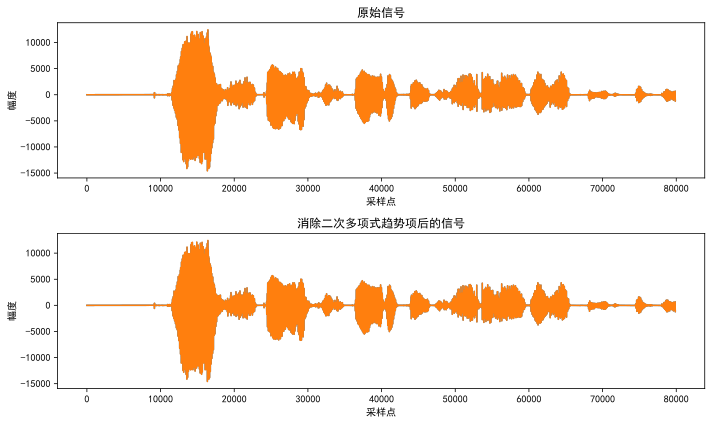

In [153]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

def detrendN(data, degree=1):
    time_axis = np.arange(len(data))  # 生成时间轴

    # 对每个通道进行多项式拟合并消除趋势项
    detrended_data = np.zeros_like(data)
    for channel in range(data.shape[1]):
        coefficients = np.polyfit(time_axis, data[:, channel], degree)  # 多项式拟合
        fitted_curve = np.polyval(coefficients, time_axis)  # 计算拟合曲线
        detrended_data[:, channel] = data[:, channel] - fitted_curve  # 消除趋势项

    return detrended_data

# 读取双声道音频文件
sample_rate, data = wavfile.read("实验3.wav")

# 消除二次多项式趋势项并绘制原始信号与处理后的信号
detrended_signal = detrendN(data, degree=2)

plt.figure(figsize=(10, 6))

# 绘制原始信号
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title("原始信号")
plt.xlabel("采样点")
plt.ylabel("幅度")

# 绘制消除趋势项后的信号
plt.subplot(2, 1, 2)
plt.plot(detrended_signal)
plt.title("消除二次多项式趋势项后的信号")
plt.xlabel("采样点")
plt.ylabel("幅度")

plt.tight_layout()
plt.show()


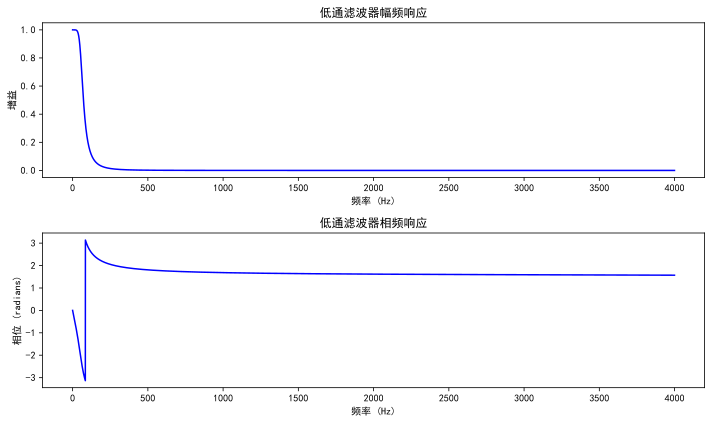

In [154]:
from scipy.signal import butter, freqz
import matplotlib.pyplot as plt
import numpy as np

# 设计指标
fs = 8000  # 采样频率
Wp = 60  # 通带截止频率
Ws = 50  # 阻带截止频率
Rp = 3  # 通带最大衰减
Rs = 80  # 阻带最小衰减

# 计算归一化截止频率
wp = Wp / (fs / 2)
ws = Ws / (fs / 2)

# 计算巴特沃斯滤波器的阶数和截止频率
N, Wn = butter(N=3, Wn=wp, btype='low', analog=False, output='ba')

# 计算滤波器的频率响应
w, h = freqz(N, Wn, worN=8000)

# 绘制幅频响应曲线
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.title("低通滤波器幅频响应")
plt.xlabel("频率 (Hz)")
plt.ylabel("增益")

# 绘制相频响应曲线
plt.subplot(2, 1, 2)
plt.plot(0.5 * fs * w / np.pi, np.angle(h), 'b')
plt.title("低通滤波器相频响应")
plt.xlabel("频率 (Hz)")
plt.ylabel("相位 (radians)")

plt.tight_layout()
plt.show()
